# Comparison between observed and modelled effects of precipitation on aerosol size distribution in the Arctic

## Zhangcheng Pei (zhangcheng.pei@utas.edu.au)
#### Australian Antarctic Program Partnership
#### University of Tasmania

## Course: “eScience Tools in Climate Science: Linking Observations with Modelling”

#### Assistant: Theodore Khadir (Group 7)

#### Date: 4 December 2022

## 1. Abstract

In this report, the influence of precipitation on aerosol size distributions in polar regions was investigated by using reanalysis data of precipitation and long-term hourly observations of particle number size distributions (PNSDs) (diameter from 10 to 400 nm) at Zeppelin Station, Svalbard for the period of 2010-2020. Additionally, the capability of NorESM2 in simulating the influence of precipitation on aerosol size distributions was evaluated against the observations. The negative effect of precipitation on particle concentrations in large Accumulation-mode was detected, which can be explained by wet scavenging. For those small particles in Aitken-mode, negative effect of recent precipitation could be explained by inhibited new particle formation during the precipitation, and positive effect of old precipitation could be explained by the weakening of condensation sink caused by wet scavenging. NorESM2 model simulates the precipitation well but need to improve the aerosol concentration simulation. Additionally, NorESM2 can catch the characteristics of wet scavenging but needs to include the condensation sink in the model setup.

## 2. Introduction

By reflecting, scattering, and absorbing solar and infrared radiation, aerosol particles have a direct impact on the Earth's radiative balance. Aerosols can regulate cloud properties such as reflectivity, absorptivity, lifetime, and precipitation by acting as ice nucleus for ice crystals and condensation nuclei for cloud droplets (Tunved et al., 2013). The majority of studies concentrate on understanding how aerosols affect clouds and precipitation processes, while few of them focus on the effects of clouds and precipitation on aerosol populations. It is critical to understand the latter influence to constrain the whole aerosol life cycle in climate models. In this project, we aim to use observational data to study the impacts of clouds and precipitation on aerosol particles and to assess how well these effects are modelled in climate models. 

**What is done in this notebook:**
- Reading PNSDs, collocated precipitation and solar radiation data at Zeppelin Station for the period of 2010-2020 from the netCDF file provided by Theodore Khadir.
- Investigating the relationship between aerosol concentrations and precipitation rate at different backward trajectory times by calculating the spearman correlation and p-value. 
- Exploring the effects of accumulated rainfall on concentrations of aerosols in different size ranges (Diameter > 100 nm, 50 nm > Diameter > 10 nm).
- Processing the NorESM2 outputs to make them comparable with observations and evaluating its ability to simulate aerosol size distribution, precipitation and their interactions.

**Hypotheses:**
- Precipitation should be a significant sink for number concentration of the Accumulation-mode particles through wet scavenging.
- By removing the Accumulation-mode particles, old precipitation can decrease the condensation sink and indirectly enhance the concentration of Aitken-mode particles that are smaller than 100 nm.
- During the recent precipitation, the solar radiation will be blocked by clouds and the new particle formation should be inhibited, resulting a decrease in Aitken-mode particles concentration.
- The NorESM2 model may underestimate the aerosol concentration and precipitation. The influence of wet scavenging should be found in the model, but influence on small particles remains uncertain.

## 3. Method

### 3.1 Packages

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from os import sys
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.linear_model import LinearRegression
sys.path.append('Tjaernoe2022-group7/zhangcheng/Function')
from Function import eScienceCourse_2022_Zhangcheng_Pei_functions as func
import warnings
warnings.filterwarnings('ignore')

### 3.2 Datasets

In this project, we use 10 years of in-situ observations (2010-2020) from Zeppelin Station, which locates at 78°54’ N, 11°53’ E and 474 meters above sea level. The data include hourly PNSDs and accumulated concentrations for different size particles. 

Global Data Assimilation System (GDAS1) reanalysis data, which has 1° x 1° spatial resolution and 6-hourly temporal resolution is used to collocate the precipitation and solar radiation along the backward trajectories.

NorESM2 model (1.875° x 2.5°, hourly, 32 levels) was run through 3 years (2015-2018). It has a series of outputs which include convective and large-scale precipitations, aerosol number concentrations, cloud fractions, and so on.

### 3.3 Analysis Methods

The aerosol concentration and precipitation rate are both very low in winter, which will affect the correlations between them. Thus, we use the data when the solar radiation is larger than 200 watts per square meter to investigate the correlations, but still use the winter data to see the accumulated rainfall's influence on particles.

In [2]:
# Read the data
filename = '~/Tjaernoe2022-group7/zhangcheng/ds_zeppelin_2010_2019.nc'
filename_model = '~/Tjaernoe2022-group7/zhangcheng/NorESM_Final.nc'
data = xr.open_dataset(filename)
model = xr.open_dataset(filename_model)

In [3]:
# Filter the dataset into different seasons
data_warm = data.sel(time=data.time.dt.month.isin([4, 5, 6, 7, 8]))
data_cold = data.sel(time=data.time.dt.month.isin([11, 12, 1, 2]))

model_warm = model.sel(time=model.time.dt.month.isin([4, 5, 6, 7, 8]))
model_cold = model.sel(time=model.time.dt.month.isin([11, 12, 1, 2]))

#### Calculate correlations between precipitation rate and particle concentration

In [4]:
# Convert the xarray dataframe to pandas dataframe for processing
precipitation_warm = pd.DataFrame(data_warm.Rainfall)
radiation_warm = pd.DataFrame(data_warm.Solar_radiation)
aerosol_warm = pd.DataFrame(data_warm.pnsd)

model_warm['Rainfall'] = (model_warm.Convective_precip + model_warm.Large_precip)*3600*1000
model_precipitation_warm = pd.DataFrame(model_warm.Rainfall)
model_precipitation_warm_non = model_precipitation_warm.where(model_precipitation_warm.isna() == False).dropna()
model_aerosol_warm = pd.DataFrame(model_warm.pnsd)
model_aerosol_warm_non = model_aerosol_warm.where(model_precipitation_warm.isna() == False).dropna()

In [5]:
# Create empty numpy arrays to store the correlation and p-value

# Aerosol concentration vs Precipitation
cor_pre = np.zeros(shape=(33,96),dtype='object')
pva_pre = np.zeros(shape=(33,96),dtype='object')
model_cor_pre = np.zeros(shape=(33,96),dtype='object')
model_pva_pre = np.zeros(shape=(33,96),dtype='object')

# Aerosol concentration vs Radiation
cor_rad = np.zeros(shape=(33,96),dtype='object')
pva_rad = np.zeros(shape=(33,96),dtype='object')

In [6]:
# Loop to calculate the correlation and p-value
for i in np.arange(33):
    for j in np.arange(96):
        cor_pre[i,j], pva_pre[i,j] = scipy.stats.spearmanr(aerosol_warm.iloc[:,i],precipitation_warm.iloc[:,j])
        
for i in np.arange(33):
    for j in np.arange(96):
        cor_rad[i,j], pva_rad[i,j] = scipy.stats.spearmanr(aerosol_warm.iloc[:,i],radiation_warm.iloc[:,j])
        
for i in np.arange(33):
    for j in np.arange(96):
        model_cor_pre[i,j], model_pva_pre[i,j] = scipy.stats.spearmanr(model_aerosol_warm_non.iloc[:,i],model_precipitation_warm_non.iloc[:,j])

In [7]:
# Change the type of the value
cor_pre = np.array(cor_pre, dtype='float')
pva_pre = np.array(pva_pre, dtype='float')

cor_rad = np.array(cor_rad, dtype='float')
pva_rad = np.array(pva_rad, dtype='float')

model_cor_pre = np.array(model_cor_pre, dtype='float')
model_pva_pre = np.array(model_pva_pre, dtype='float')

In [8]:
# Build the mask for plotting

# For x-axis (Diameter)
Dp = data.D.values
logDp = np.log10(Dp)
interval = np.array([logDp[i]-logDp[i-1] for i in range(1,np.size(Dp))])/2
centers = logDp[:-1]+interval
centers_bis = np.append(logDp[0]-interval[0], centers)
centers_bis = np.append(centers_bis, logDp[-1]+interval[-1])
bound_bins = 10**(centers_bis)

# For y-axis (Backward time trajectories)
time_traj = np.arange(98)
interval = np.zeros(shape=(97))
interval[:] = 0.5
centers = time_traj[:-1] + interval[:]

#### Calculate accumulated particle concentrations and precipitation

In [9]:
# Integrate aerosol concentrations that are larger than 100 nm in the datasets
func.pnsd_integration(data_warm,100)
func.pnsd_integration(data_cold,100)

In [10]:
# Integrate the precipitation along the trajectory for 96 hours (whole precipitation)
data_warm['Accumulated_Rainfall'] = data_warm['Rainfall'].sum(dim='time_traj')
data_cold['Accumulated_Rainfall'] = data_cold['Rainfall'].sum(dim='time_traj')

# Integrate the precipitation along the trajectory for 6 hours (recent precipitation)
data_warm['Accumulated_Rainfall_6h'] = data_warm['Rainfall'].sel(time_traj=slice(0, 6)).sum(dim='time_traj')
data_cold['Accumulated_Rainfall_6h'] = data_cold['Rainfall'].sel(time_traj=slice(0, 6)).sum(dim='time_traj')

In [11]:
# Convert data to pandas dataframe to process

# For warm months (4,5,6,7,8)
N100_warm = pd.Series(data_warm.N100,name='N100')
N10_50_warm = pd.Series(data_warm.conc_10_50,name='N10_50')

Precip_96_warm = pd.Series(data_warm.Accumulated_Rainfall,name='Accumulated_Rainfall')
N100_96_warm = pd.concat([Precip_96_warm,N100_warm],axis=1)
N10_50_96_warm = pd.concat([Precip_96_warm,N10_50_warm],axis=1)

Precip_6_warm = pd.Series(data_warm.Accumulated_Rainfall_6h,name='Accumulated_Rainfall_6h')
N100_6_warm = pd.concat([Precip_6_warm,N100_warm],axis=1)
N10_50_6_warm = pd.concat([Precip_6_warm,N10_50_warm],axis=1)

# For cold months (11,12,1,2)
N100_cold = pd.Series(data_cold.N100,name='N100')
N10_50_cold = pd.Series(data_cold.conc_10_50,name='N10_50')

Precip_96_cold = pd.Series(data_cold.Accumulated_Rainfall,name='Accumulated_Rainfall')
N100_96_cold = pd.concat([Precip_96_cold,N100_cold],axis=1)
N10_50_96_cold = pd.concat([Precip_96_cold,N10_50_cold],axis=1)

Precip_6_cold = pd.Series(data_cold.Accumulated_Rainfall_6h,name='Accumulated_Rainfall_6h')
N100_6_cold = pd.concat([Precip_6_cold,N100_cold],axis=1)
N10_50_6_cold = pd.concat([Precip_6_cold,N10_50_cold],axis=1)

In [12]:
# Add the bin for grouping the precipitation interval

# For warm months (4,5,6,7,8)
N100_96_warm['interval'] = N100_96_warm['Accumulated_Rainfall'].round(0)
N10_50_96_warm['interval'] = N10_50_96_warm['Accumulated_Rainfall'].round(0)

N100_6_warm['interval'] = N100_6_warm['Accumulated_Rainfall_6h'].round(0)
N10_50_6_warm['interval'] = N10_50_6_warm['Accumulated_Rainfall_6h'].round(0)

# For cold months (11,12,1,2)
N100_96_cold['interval'] = N100_96_cold['Accumulated_Rainfall'].round(0)
N10_50_96_cold['interval'] = N10_50_96_cold['Accumulated_Rainfall'].round(0)

N100_6_cold['interval'] = N100_6_cold['Accumulated_Rainfall_6h'].round(0)
N10_50_6_cold['interval'] = N10_50_6_cold['Accumulated_Rainfall_6h'].round(0)

In [13]:
# Calculate the statistics

# For warm months (4,5,6,7,8)

# Median
N100_96_warm_med = N100_96_warm.groupby('interval').median().where(N100_96_warm.groupby('interval').count() > 10)
N10_50_96_warm_med = N10_50_96_warm.groupby('interval').median().where(N10_50_96_warm.groupby('interval').count() > 10)

# 25th quantile
N100_96_warm_25th = N100_96_warm.groupby('interval').quantile(q=0.25).where(N100_96_warm.groupby('interval').count() > 10)
N10_50_96_warm_25th = N10_50_96_warm.groupby('interval').quantile(q=0.25).where(N10_50_96_warm.groupby('interval').count() > 10)

# 75 quantile
N100_96_warm_75th = N100_96_warm.groupby('interval').quantile(q=0.75).where(N100_96_warm.groupby('interval').count() > 10)
N10_50_96_warm_75th = N10_50_96_warm.groupby('interval').quantile(q=0.75).where(N10_50_96_warm.groupby('interval').count() > 10)

# Median
N100_6_warm_med = N100_6_warm.groupby('interval').median().where(N100_6_warm.groupby('interval').count() > 10)
N10_50_6_warm_med = N10_50_6_warm.groupby('interval').median().where(N10_50_6_warm.groupby('interval').count() > 10)

# 25th quantile
N100_6_warm_25th = N100_6_warm.groupby('interval').quantile(q=0.25).where(N100_6_warm.groupby('interval').count() > 10)
N10_50_6_warm_25th = N10_50_6_warm.groupby('interval').quantile(q=0.25).where(N10_50_6_warm.groupby('interval').count() > 10)

# 75 quantile
N100_6_warm_75th = N100_6_warm.groupby('interval').quantile(q=0.75).where(N100_6_warm.groupby('interval').count() > 10)
N10_50_6_warm_75th = N10_50_6_warm.groupby('interval').quantile(q=0.75).where(N10_50_6_warm.groupby('interval').count() > 10)

In [14]:
# For cold months (11,12,1,2)

# Median
N100_96_cold_med = N100_96_cold.groupby('interval').median().where(N100_96_cold.groupby('interval').count() > 10)
N10_50_96_cold_med = N10_50_96_cold.groupby('interval').median().where(N10_50_96_cold.groupby('interval').count() > 10)

# 25th quantile
N100_96_cold_25th = N100_96_cold.groupby('interval').quantile(q=0.25).where(N100_96_cold.groupby('interval').count() > 10)
N10_50_96_cold_25th = N10_50_96_cold.groupby('interval').quantile(q=0.25).where(N10_50_96_cold.groupby('interval').count() > 10)

# 75 quantile
N100_96_cold_75th = N100_96_cold.groupby('interval').quantile(q=0.75).where(N100_96_cold.groupby('interval').count() > 10)
N10_50_96_cold_75th = N10_50_96_cold.groupby('interval').quantile(q=0.75).where(N10_50_96_cold.groupby('interval').count() > 10)

# Median
N100_6_cold_med = N100_6_cold.groupby('interval').median().where(N100_6_cold.groupby('interval').count() > 10)
N10_50_6_cold_med = N10_50_6_cold.groupby('interval').median().where(N10_50_6_cold.groupby('interval').count() > 10)

# 25th quantile
N100_6_cold_25th = N100_6_cold.groupby('interval').quantile(q=0.25).where(N100_6_cold.groupby('interval').count() > 10)
N10_50_6_cold_25th = N10_50_6_cold.groupby('interval').quantile(q=0.25).where(N10_50_6_cold.groupby('interval').count() > 10)

# 75 quantile
N100_6_cold_75th = N100_6_cold.groupby('interval').quantile(q=0.75).where(N100_6_cold.groupby('interval').count() > 10)
N10_50_6_cold_75th = N10_50_6_cold.groupby('interval').quantile(q=0.75).where(N10_50_6_cold.groupby('interval').count() > 10)

In [15]:
# Build new pandas dataframe for calculating the linear relationship

# For warm months (4,5,6,7,8)
N100_96_warm_med_linear = pd.concat([pd.Series(N100_96_warm_med.index),pd.Series(N100_96_warm_med.N100)],axis=1).dropna()
N10_50_96_warm_med_linear = pd.concat([pd.Series(N10_50_96_warm_med.index),pd.Series(N10_50_96_warm_med.N10_50)],axis=1).dropna()
N100_96_warm_25th_linear = pd.concat([pd.Series(N100_96_warm_25th.index),pd.Series(N100_96_warm_25th.N100)],axis=1).dropna()
N10_50_96_warm_25th_linear = pd.concat([pd.Series(N10_50_96_warm_25th.index),pd.Series(N10_50_96_warm_25th.N10_50)],axis=1).dropna()
N100_96_warm_75th_linear = pd.concat([pd.Series(N100_96_warm_75th.index),pd.Series(N100_96_warm_75th.N100)],axis=1).dropna()
N10_50_96_warm_75th_linear = pd.concat([pd.Series(N10_50_96_warm_75th.index),pd.Series(N10_50_96_warm_75th.N10_50)],axis=1).dropna()
N100_6_warm_med_linear = pd.concat([pd.Series(N100_6_warm_med.index),pd.Series(N100_6_warm_med.N100)],axis=1).dropna()
N10_50_6_warm_med_linear = pd.concat([pd.Series(N10_50_6_warm_med.index),pd.Series(N10_50_6_warm_med.N10_50)],axis=1).dropna()
N100_6_warm_25th_linear = pd.concat([pd.Series(N100_6_warm_25th.index),pd.Series(N100_6_warm_25th.N100)],axis=1).dropna()
N10_50_6_warm_25th_linear = pd.concat([pd.Series(N10_50_6_warm_25th.index),pd.Series(N10_50_6_warm_25th.N10_50)],axis=1).dropna()
N100_6_warm_75th_linear = pd.concat([pd.Series(N100_6_warm_75th.index),pd.Series(N100_6_warm_75th.N100)],axis=1).dropna()
N10_50_6_warm_75th_linear = pd.concat([pd.Series(N10_50_6_warm_75th.index),pd.Series(N10_50_6_warm_75th.N10_50)],axis=1).dropna()

# For cold months (11,12,1,2)
N100_96_cold_med_linear = pd.concat([pd.Series(N100_96_cold_med.index),pd.Series(N100_96_cold_med.N100)],axis=1).dropna()
N10_50_96_cold_med_linear = pd.concat([pd.Series(N10_50_96_cold_med.index),pd.Series(N10_50_96_cold_med.N10_50)],axis=1).dropna()
N100_96_cold_25th_linear = pd.concat([pd.Series(N100_96_cold_25th.index),pd.Series(N100_96_cold_25th.N100)],axis=1).dropna()
N10_50_96_cold_25th_linear = pd.concat([pd.Series(N10_50_96_cold_25th.index),pd.Series(N10_50_96_cold_25th.N10_50)],axis=1).dropna()
N100_96_cold_75th_linear = pd.concat([pd.Series(N100_96_cold_75th.index),pd.Series(N100_96_cold_75th.N100)],axis=1).dropna()
N10_50_96_cold_75th_linear = pd.concat([pd.Series(N10_50_96_cold_75th.index),pd.Series(N10_50_96_cold_75th.N10_50)],axis=1).dropna()
N100_6_cold_med_linear = pd.concat([pd.Series(N100_6_cold_med.index),pd.Series(N100_6_cold_med.N100)],axis=1).dropna()
N10_50_6_cold_med_linear = pd.concat([pd.Series(N10_50_6_cold_med.index),pd.Series(N10_50_6_cold_med.N10_50)],axis=1).dropna()
N100_6_cold_25th_linear = pd.concat([pd.Series(N100_6_cold_25th.index),pd.Series(N100_6_cold_25th.N100)],axis=1).dropna()
N10_50_6_cold_25th_linear = pd.concat([pd.Series(N10_50_6_cold_25th.index),pd.Series(N10_50_6_cold_25th.N10_50)],axis=1).dropna()
N100_6_cold_75th_linear = pd.concat([pd.Series(N100_6_cold_75th.index),pd.Series(N100_6_cold_75th.N100)],axis=1).dropna()
N10_50_6_cold_75th_linear = pd.concat([pd.Series(N10_50_6_cold_75th.index),pd.Series(N10_50_6_cold_75th.N10_50)],axis=1).dropna()

In [16]:
# As the accumulated precipitation and aerosol concentration differ in different season, we further normalize the data to look at the relationship
nor_N100_96_warm = func.normalize(N100_96_warm_med_linear)
nor_N10_50_96_warm = func.normalize(N10_50_96_warm_med_linear)
nor_N100_6_warm = func.normalize(N100_6_warm_med_linear)
nor_N10_50_6_warm = func.normalize(N10_50_6_warm_med_linear)
nor_N100_96_cold = func.normalize(N100_96_cold_med_linear)
nor_N10_50_96_cold = func.normalize(N10_50_96_cold_med_linear)
nor_N100_6_cold = func.normalize(N100_6_cold_med_linear)
nor_N10_50_6_cold = func.normalize(N10_50_6_cold_med_linear)

In [17]:
# Fit the data with linear regression
Reg_N100_96_warm = LinearRegression().fit(np.array(nor_N100_96_warm.interval).reshape(-1,1),np.array(nor_N100_96_warm.N100))
Reg_N10_50_96_warm = LinearRegression().fit(np.array(nor_N10_50_96_warm.interval).reshape(-1,1),np.array(nor_N10_50_96_warm.N10_50))
Reg_N100_6_warm = LinearRegression().fit(np.array(nor_N100_6_warm.interval).reshape(-1,1),np.array(nor_N100_6_warm.N100))
Reg_N10_50_6_warm = LinearRegression().fit(np.array(nor_N10_50_6_warm.interval).reshape(-1,1),np.array(nor_N10_50_6_warm.N10_50))
Reg_N100_96_cold = LinearRegression().fit(np.array(nor_N100_96_cold.interval).reshape(-1,1),np.array(nor_N100_96_cold.N100))
Reg_N10_50_96_cold = LinearRegression().fit(np.array(nor_N10_50_96_cold.interval).reshape(-1,1),np.array(nor_N10_50_96_cold.N10_50))
Reg_N100_6_cold = LinearRegression().fit(np.array(nor_N100_6_cold.interval).reshape(-1,1),np.array(nor_N100_6_cold.N100))
Reg_N10_50_6_cold = LinearRegression().fit(np.array(nor_N10_50_6_cold.interval).reshape(-1,1),np.array(nor_N10_50_6_cold.N10_50))

In [18]:
# Get the predicted value
pred_N100_96_warm = Reg_N100_96_warm.predict(np.array(nor_N100_96_warm.interval).reshape(-1,1))
pred_N10_50_96_warm = Reg_N10_50_96_warm.predict(np.array(nor_N10_50_96_warm.interval).reshape(-1,1))
pred_N100_6_warm = Reg_N100_6_warm.predict(np.array(nor_N100_6_warm.interval).reshape(-1,1))
pred_N10_50_6_warm = Reg_N10_50_6_warm.predict(np.array(nor_N10_50_6_warm.interval).reshape(-1,1))
pred_N100_96_cold = Reg_N100_96_cold.predict(np.array(nor_N100_96_cold.interval).reshape(-1,1))
pred_N10_50_96_cold = Reg_N10_50_96_cold.predict(np.array(nor_N10_50_96_cold.interval).reshape(-1,1))
pred_N100_6_cold = Reg_N100_6_cold.predict(np.array(nor_N100_6_cold.interval).reshape(-1,1))
pred_N10_50_6_cold = Reg_N10_50_6_cold.predict(np.array(nor_N10_50_6_cold.interval).reshape(-1,1))

In [19]:
# Get the parameters (coefficients, intercepts, and R squared value)
para_N100_96_warm = [Reg_N100_96_warm.coef_, Reg_N100_96_warm.intercept_, Reg_N100_96_warm.score(np.array(nor_N100_96_warm.interval).reshape(-1,1),np.array(nor_N100_96_warm.N100))]
para_N10_50_96_warm = [Reg_N10_50_96_warm.coef_, Reg_N10_50_96_warm.intercept_, Reg_N10_50_96_warm.score(np.array(nor_N10_50_96_warm.interval).reshape(-1,1),np.array(nor_N10_50_96_warm.N10_50))]
para_N100_6_warm = [Reg_N100_6_warm.coef_, Reg_N100_6_warm.intercept_, Reg_N100_6_warm.score(np.array(nor_N100_6_warm.interval).reshape(-1,1),np.array(nor_N100_6_warm.N100))]
para_N10_50_6_warm = [Reg_N10_50_6_warm.coef_, Reg_N10_50_6_warm.intercept_, Reg_N10_50_6_warm.score(np.array(nor_N10_50_6_warm.interval).reshape(-1,1),np.array(nor_N10_50_6_warm.N10_50))]
para_N100_96_cold = [Reg_N100_96_cold.coef_, Reg_N100_96_cold.intercept_, Reg_N100_96_cold.score(np.array(nor_N100_96_cold.interval).reshape(-1,1),np.array(nor_N100_96_cold.N100))]
para_N10_50_96_cold = [Reg_N10_50_96_cold.coef_, Reg_N10_50_96_cold.intercept_, Reg_N10_50_96_cold.score(np.array(nor_N10_50_96_cold.interval).reshape(-1,1),np.array(nor_N10_50_96_cold.N10_50))]
para_N100_6_cold = [Reg_N100_6_cold.coef_, Reg_N100_6_cold.intercept_, Reg_N100_6_cold.score(np.array(nor_N100_6_cold.interval).reshape(-1,1),np.array(nor_N100_6_cold.N100))]
para_N10_50_6_cold = [Reg_N10_50_6_cold.coef_, Reg_N10_50_6_cold.intercept_, Reg_N10_50_6_cold.score(np.array(nor_N10_50_6_cold.interval).reshape(-1,1),np.array(nor_N10_50_6_cold.N10_50))]

## 4. Result and Discussion

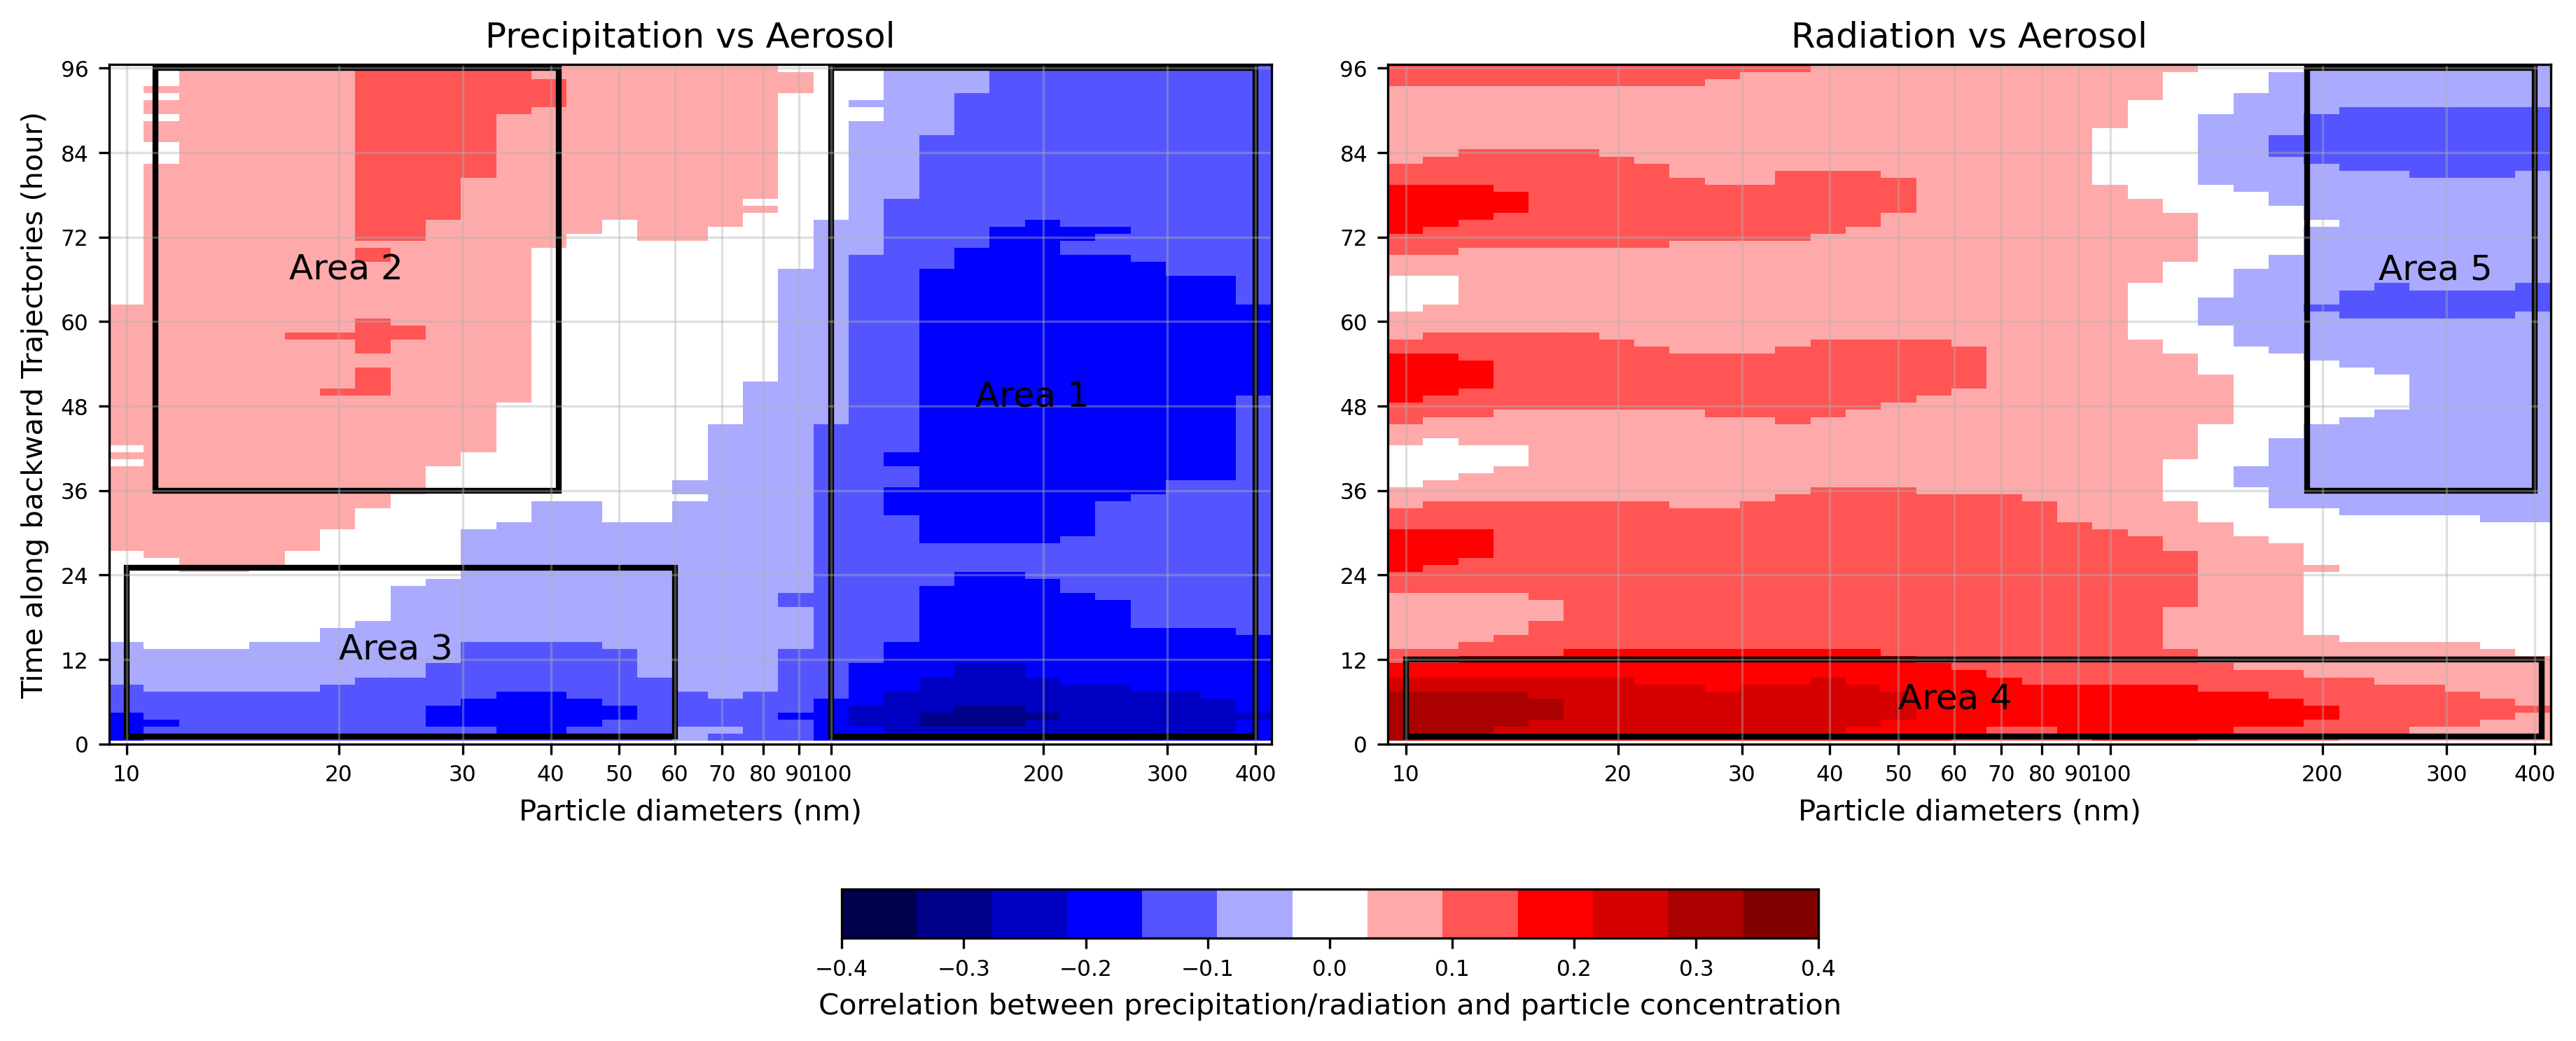

In [20]:
# Figure 1
fig = plt.figure(figsize=(15,6), dpi=300)
plt.subplots_adjust(wspace=0.1)

X, Y = np.meshgrid(centers,bound_bins)
cmap = plt.get_cmap('seismic',lut=13)

ax1 = plt.subplot(1,2,1)

c1 = ax1.pcolor(Y, X, cor_pre, cmap=cmap, vmax=0.4, vmin=-0.4)
ax1.set_xscale('log')
ax1.set_xticks([10,20,30,40,50,60,70,80,90,100,200,300,400])
ax1.set_yticks(np.arange(0,97,12))
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.tick_params(axis='both', which='major', labelsize=7.5)
plt.title('Precipitation vs Aerosol',fontsize=12)
plt.xlabel('Particle diameters (nm)',fontsize=10)
plt.ylabel('Time along backward Trajectories (hour)',fontsize=10)
plt.grid(alpha=0.4)
plt.gca().add_patch(matplotlib.patches.Rectangle((10,1),50,24, edgecolor='black',facecolor='none',lw=2))
plt.gca().add_patch(matplotlib.patches.Rectangle((100,1),300,95, edgecolor='black',facecolor='none',lw=2))
plt.gca().add_patch(matplotlib.patches.Rectangle((11,36),30,60, edgecolor='black',facecolor='none',lw=2))
plt.text(160, 48, 'Area 1', fontsize = 12)
plt.text(17, 66, 'Area 2', fontsize = 12)
plt.text(20, 12, 'Area 3', fontsize = 12)


ax2 = plt.subplot(1,2,2)
c2 = ax2.pcolor(Y, X, cor_rad, cmap=cmap, vmax=0.4, vmin=-0.4)
ax2.set_xscale('log')
ax2.set_xticks([10,20,30,40,50,60,70,80,90,100,200,300,400])
ax2.set_yticks(np.arange(0,97,12))
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.tick_params(axis='both', which='major', labelsize=7.5)
plt.title('Radiation vs Aerosol',fontsize=12)
plt.xlabel('Particle diameters (nm)',fontsize=10)
plt.grid(alpha=0.4)
plt.gca().add_patch(matplotlib.patches.Rectangle((10,1),399,11, edgecolor='black',facecolor='none',lw=2))
plt.gca().add_patch(matplotlib.patches.Rectangle((190,36),210,60, edgecolor='black',facecolor='none',lw=2))
plt.text(50, 5, 'Area 4', fontsize = 12)
plt.text(240, 66, 'Area 5', fontsize = 12)

cb = fig.colorbar(c1, ax=[ax1,ax2], shrink=0.4, location='bottom')
cb.ax.tick_params(labelsize=7.5)
cb.set_label(label='Correlation between precipitation/radiation and particle concentration',size=10)

Figure 1: Correlation between precipitation rate (left), solar radiation (right) and particle number size distribution at given time steps of the 96h backward airmass trajectories. Different areas indicate different effects of precipitation on aerosol populations.

For the correlation between precipitation rate and particle number size distribution (Figure 1, left), a strong negative effect of precipitation on accumulation mode particles (100 nm < D < 400 nm) concentration can be found in Area 1. This effect covers the whole 96 hours backward trajectories. In Area 2, concentration of particles in aitken mode (10 nm < D < 50 nm) can be enhanced by the precipitation. Nevertheless, this effect only appears in past precipitation at least 24 hours ago. For the effect of recent precipitation on aitken mode particles (Area 3), instead, precipitation can be a sink for these aitken mode particles. 

The negative effect of precipitation on aerosol concentration in Area 1 can be attributed to the wet scavenging, which is the most important sink for the atmospheric particulate mass and number concentration of the accumulation mode particles (> 100 nm) (Seinfeld and Pandis, 2006). Wet scavenging consists of two processes, one is through rainout: particles that are big enough can activate and create cloud droplets under the proper thermodynamic circumstances, if these droplets grow large enough, the cloud can precipitate and scavenge the atmospheric particles. Another process is through washout: particles underneath a cloud that is precipitating can collide with the falling droplets, get trapped, and then descend to the ground (Seinfeld and Pandis, 2006). To explain the situation in Area 2, Figure 1, it can be caused by removal of accumulation mode particles, which weakens the coagulation and condensation of vapors and smaller particles onto larger ones, thus enhancing the lifetime of small particles. (e.g. Riipinen et al., 2011; Westervelt et al., 2013). Moreover, the Area 3 in Figure 1 indicates the block of solar radiation by increasing cloud fraction during precipitation, resulting in inhibition of new particle formation and decreasing the aitken mode particle concentrations. This effect will be further investigated in Figure 2 and 3.

For the correlation between solar radiation and particle number size distribution (Figure 1, right), there is a significant postive effect of solar radiation on particles at all sizes. This influence is strengthened for smaller particles, which is obvious in Area 4. Moreover, a diurnal cycle (12 hours) of solar radiation can be observed through the time trajectories (y-axis). For Area 5, the slight negative effects on accumulation mode particles is tricky to explain, which may be the consequence of the weaker solar radiation along the backward trajectory (The particles move southward, where the solar radiation will decline in summer at the Northern Hemisphere).

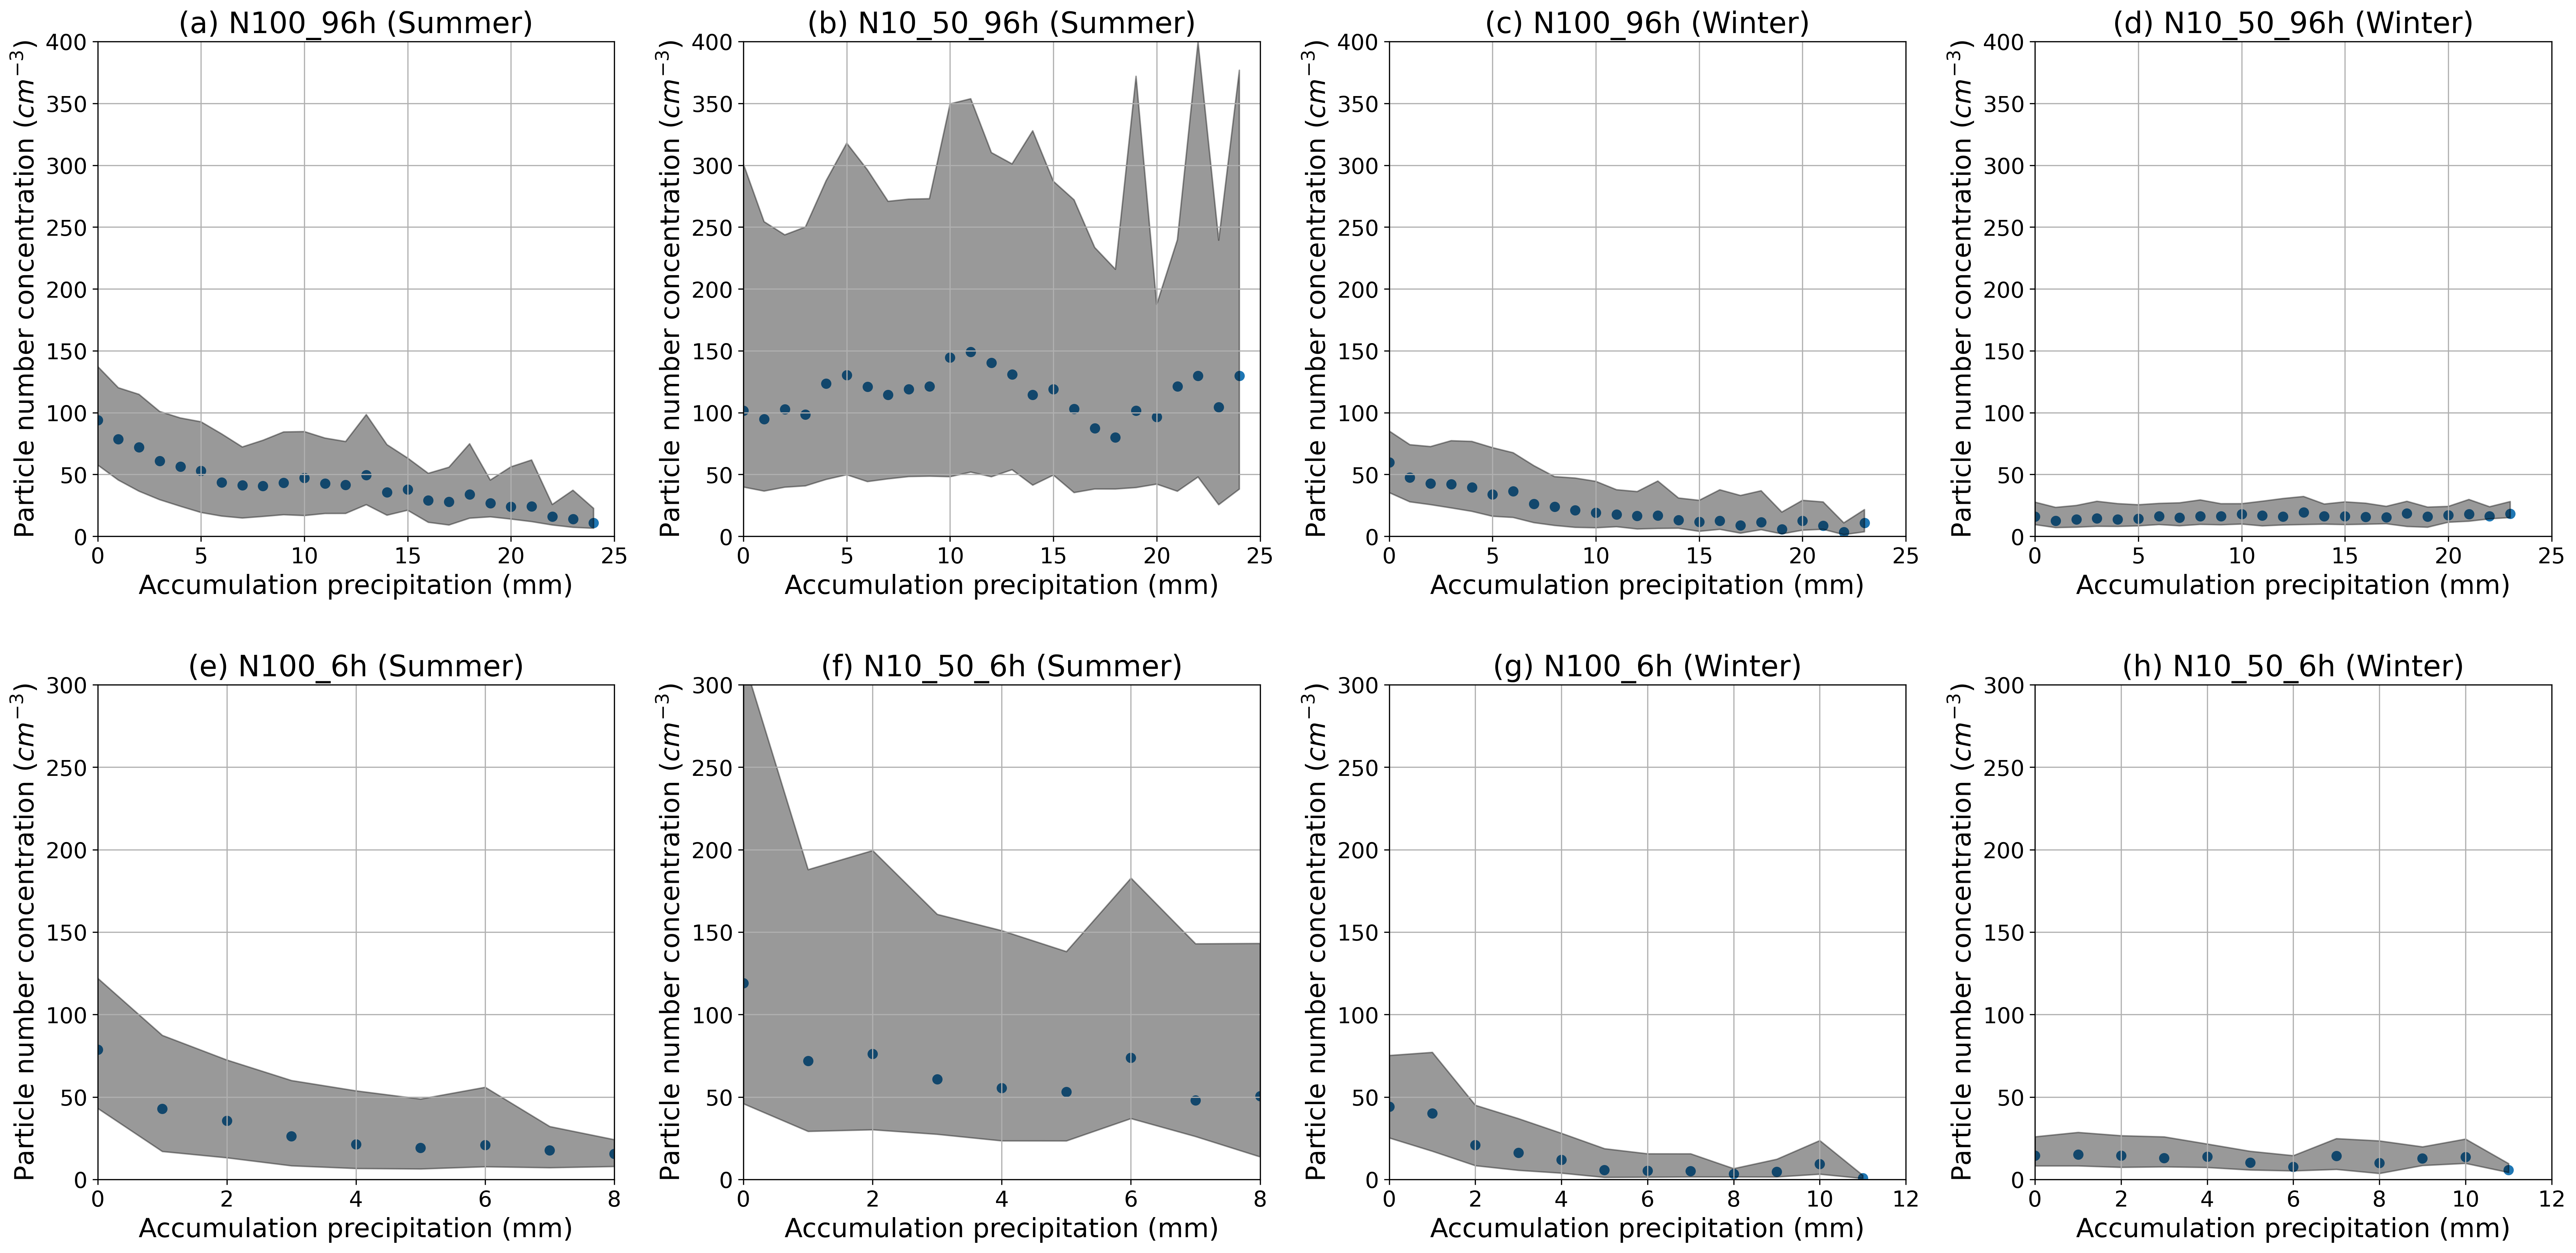

In [21]:
# Figure 2
fig = plt.figure(figsize=(30,14),dpi=300)
plt.subplots_adjust(hspace=0.3, wspace=0.25)

ax1 = plt.subplot(241)

plt.scatter(N100_96_warm_med.index, N100_96_warm_med.N100)
plt.fill_between(N100_96_warm_med.index, N100_96_warm_25th.N100,N100_96_warm_75th.N100,color="k", alpha = 0.4)
plt.xlim(0,25)
plt.ylim(0,400)
plt.xlabel('Accumulation precipitation (mm)',fontsize=18)
plt.ylabel('Particle number concentration ($cm^{-3}$)',fontsize=18)
plt.title('(a) N100_96h (Summer)',fontsize=20)
ax1.tick_params(axis='both', labelsize=15)
plt.grid()

ax2 = plt.subplot(242)
plt.scatter(N10_50_96_warm_med.index, N10_50_96_warm_med.N10_50)
plt.fill_between(N10_50_96_warm_med.index, N10_50_96_warm_25th.N10_50,N10_50_96_warm_75th.N10_50,color="k", alpha = 0.4)
plt.xlim(0,25)
plt.ylim(0,400)
plt.xlabel('Accumulation precipitation (mm)',fontsize=18)
plt.ylabel('Particle number concentration ($cm^{-3}$)',fontsize=18)
plt.title('(b) N10_50_96h (Summer)',fontsize=20)
ax2.tick_params(axis='both', labelsize=15)
plt.grid()

ax3 = plt.subplot(245)
plt.scatter(N100_6_warm_med.index, N100_6_warm_med.N100)
plt.fill_between(N100_6_warm_med.index, N100_6_warm_25th.N100,N100_6_warm_75th.N100,color="k", alpha = 0.4)
plt.xlim(0,8)
plt.ylim(0,300)
plt.xlabel('Accumulation precipitation (mm)',fontsize=18)
plt.ylabel('Particle number concentration ($cm^{-3}$)',fontsize=18)
plt.title('(e) N100_6h (Summer)',fontsize=20)
ax3.tick_params(axis='both', labelsize=15)
plt.grid()

ax4 = plt.subplot(246)
plt.scatter(N10_50_6_warm_med.index, N10_50_6_warm_med.N10_50)
plt.fill_between(N10_50_6_warm_med.index, N10_50_6_warm_25th.N10_50,N10_50_6_warm_75th.N10_50,color="k", alpha = 0.4)
plt.xlim(0,8)
plt.ylim(0,300)
plt.xlabel('Accumulation precipitation (mm)',fontsize=18)
plt.ylabel('Particle number concentration ($cm^{-3}$)',fontsize=18)
plt.title('(f) N10_50_6h (Summer)',fontsize=20)
ax4.tick_params(axis='both', labelsize=15)
plt.grid()

ax5 = plt.subplot(243)

plt.scatter(N100_96_cold_med.index, N100_96_cold_med.N100)
plt.fill_between(N100_96_cold_med.index, N100_96_cold_25th.N100,N100_96_cold_75th.N100,color="k", alpha = 0.4)
plt.xlim(0,25)
plt.ylim(0,400)
plt.xlabel('Accumulation precipitation (mm)',fontsize=18)
plt.ylabel('Particle number concentration ($cm^{-3}$)',fontsize=18)
plt.title('(c) N100_96h (Winter)',fontsize=20)
ax5.tick_params(axis='both', labelsize=15)
plt.grid()

ax6 = plt.subplot(244)
plt.scatter(N10_50_96_cold_med.index, N10_50_96_cold_med.N10_50)
plt.fill_between(N10_50_96_cold_med.index, N10_50_96_cold_25th.N10_50,N10_50_96_cold_75th.N10_50,color="k", alpha = 0.4)
plt.xlim(0,25)
plt.ylim(0,400)
plt.xlabel('Accumulation precipitation (mm)',fontsize=18)
plt.ylabel('Particle number concentration ($cm^{-3}$)',fontsize=18)
plt.title('(d) N10_50_96h (Winter)',fontsize=20)
ax6.tick_params(axis='both', labelsize=15)
plt.grid()

ax7 = plt.subplot(247)
plt.scatter(N100_6_cold_med.index, N100_6_cold_med.N100)
plt.fill_between(N100_6_cold_med.index, N100_6_cold_25th.N100,N100_6_cold_75th.N100,color="k", alpha = 0.4)
plt.xlim(0,12)
plt.ylim(0,300)
plt.xlabel('Accumulation precipitation (mm)',fontsize=18)
plt.ylabel('Particle number concentration ($cm^{-3}$)',fontsize=18)
plt.title('(g) N100_6h (Winter)',fontsize=20)
ax7.tick_params(axis='both', labelsize=15)
plt.grid()

ax8 = plt.subplot(248)
plt.scatter(N10_50_6_cold_med.index, N10_50_6_cold_med.N10_50)
plt.fill_between(N10_50_6_cold_med.index, N10_50_6_cold_25th.N10_50,N10_50_6_cold_75th.N10_50,color="k", alpha = 0.4)
plt.xlim(0,12)
plt.ylim(0,300)
plt.xlabel('Accumulation precipitation (mm)',fontsize=18)
plt.ylabel('Particle number concentration ($cm^{-3}$)',fontsize=18)
plt.title('(h) N10_50_6h (Winter)',fontsize=20)
ax8.tick_params(axis='both', labelsize=15)
plt.grid()

Figure 2: The relationship between accumulated precipitation over 6 hours (a,b,c,d) and 96 hours (e,f,g,h), and accumulated particle concentrations at Diameter > 100 nm (a,c,e,g) and 50 nm > Diameter > 10 nm (b,d,f,h) in summer (a,b,e,f) and winter (c,d,g,h). Blue point is the median value and shaded area is the 25th and 75th quantile.

According to Figure 2a, c, e, g, we can observe that the concentration of large particles whose diameter are larger than 100 nm tend to decrease when the accumulated precipitation increases in both accumulated time (6h and 96h) and both seasons (summer and winter). The effect of wet scavenging is fairly evident here.

For small particles, influence of accumulated precipitation are more complex. In summer, particle number concentration tends to increase before the accumulated rainfall reaches 10 mm (Figure 2b). After that, the concentration decreases as rainfall increases. When the rainfall reaches 18 mm, the particle concentration becomes fluctuated. In Figure 2f, there is a large drop of concentration from 120 $cm^{-3}$ to 75 $cm^{-3}$ when it starts raining. In winter (Figure 2d, h), the changes of particle concentration are not pronounced along the accumulated precipitation. The significant decline of small particle concentrations with precipitation in summer (Figure 2f) indicates that blocked solar radiation by more cloud fraction during precipitation inhibites the new particle formation, as this effect is not apparent in winter, when there are less solar radiation (Figure 2h).

While the magnitudes of rainfall rate and particle concentrations are different in summer and winter, these data are normalized in Figure 3 to see the actual influence of precipitation.

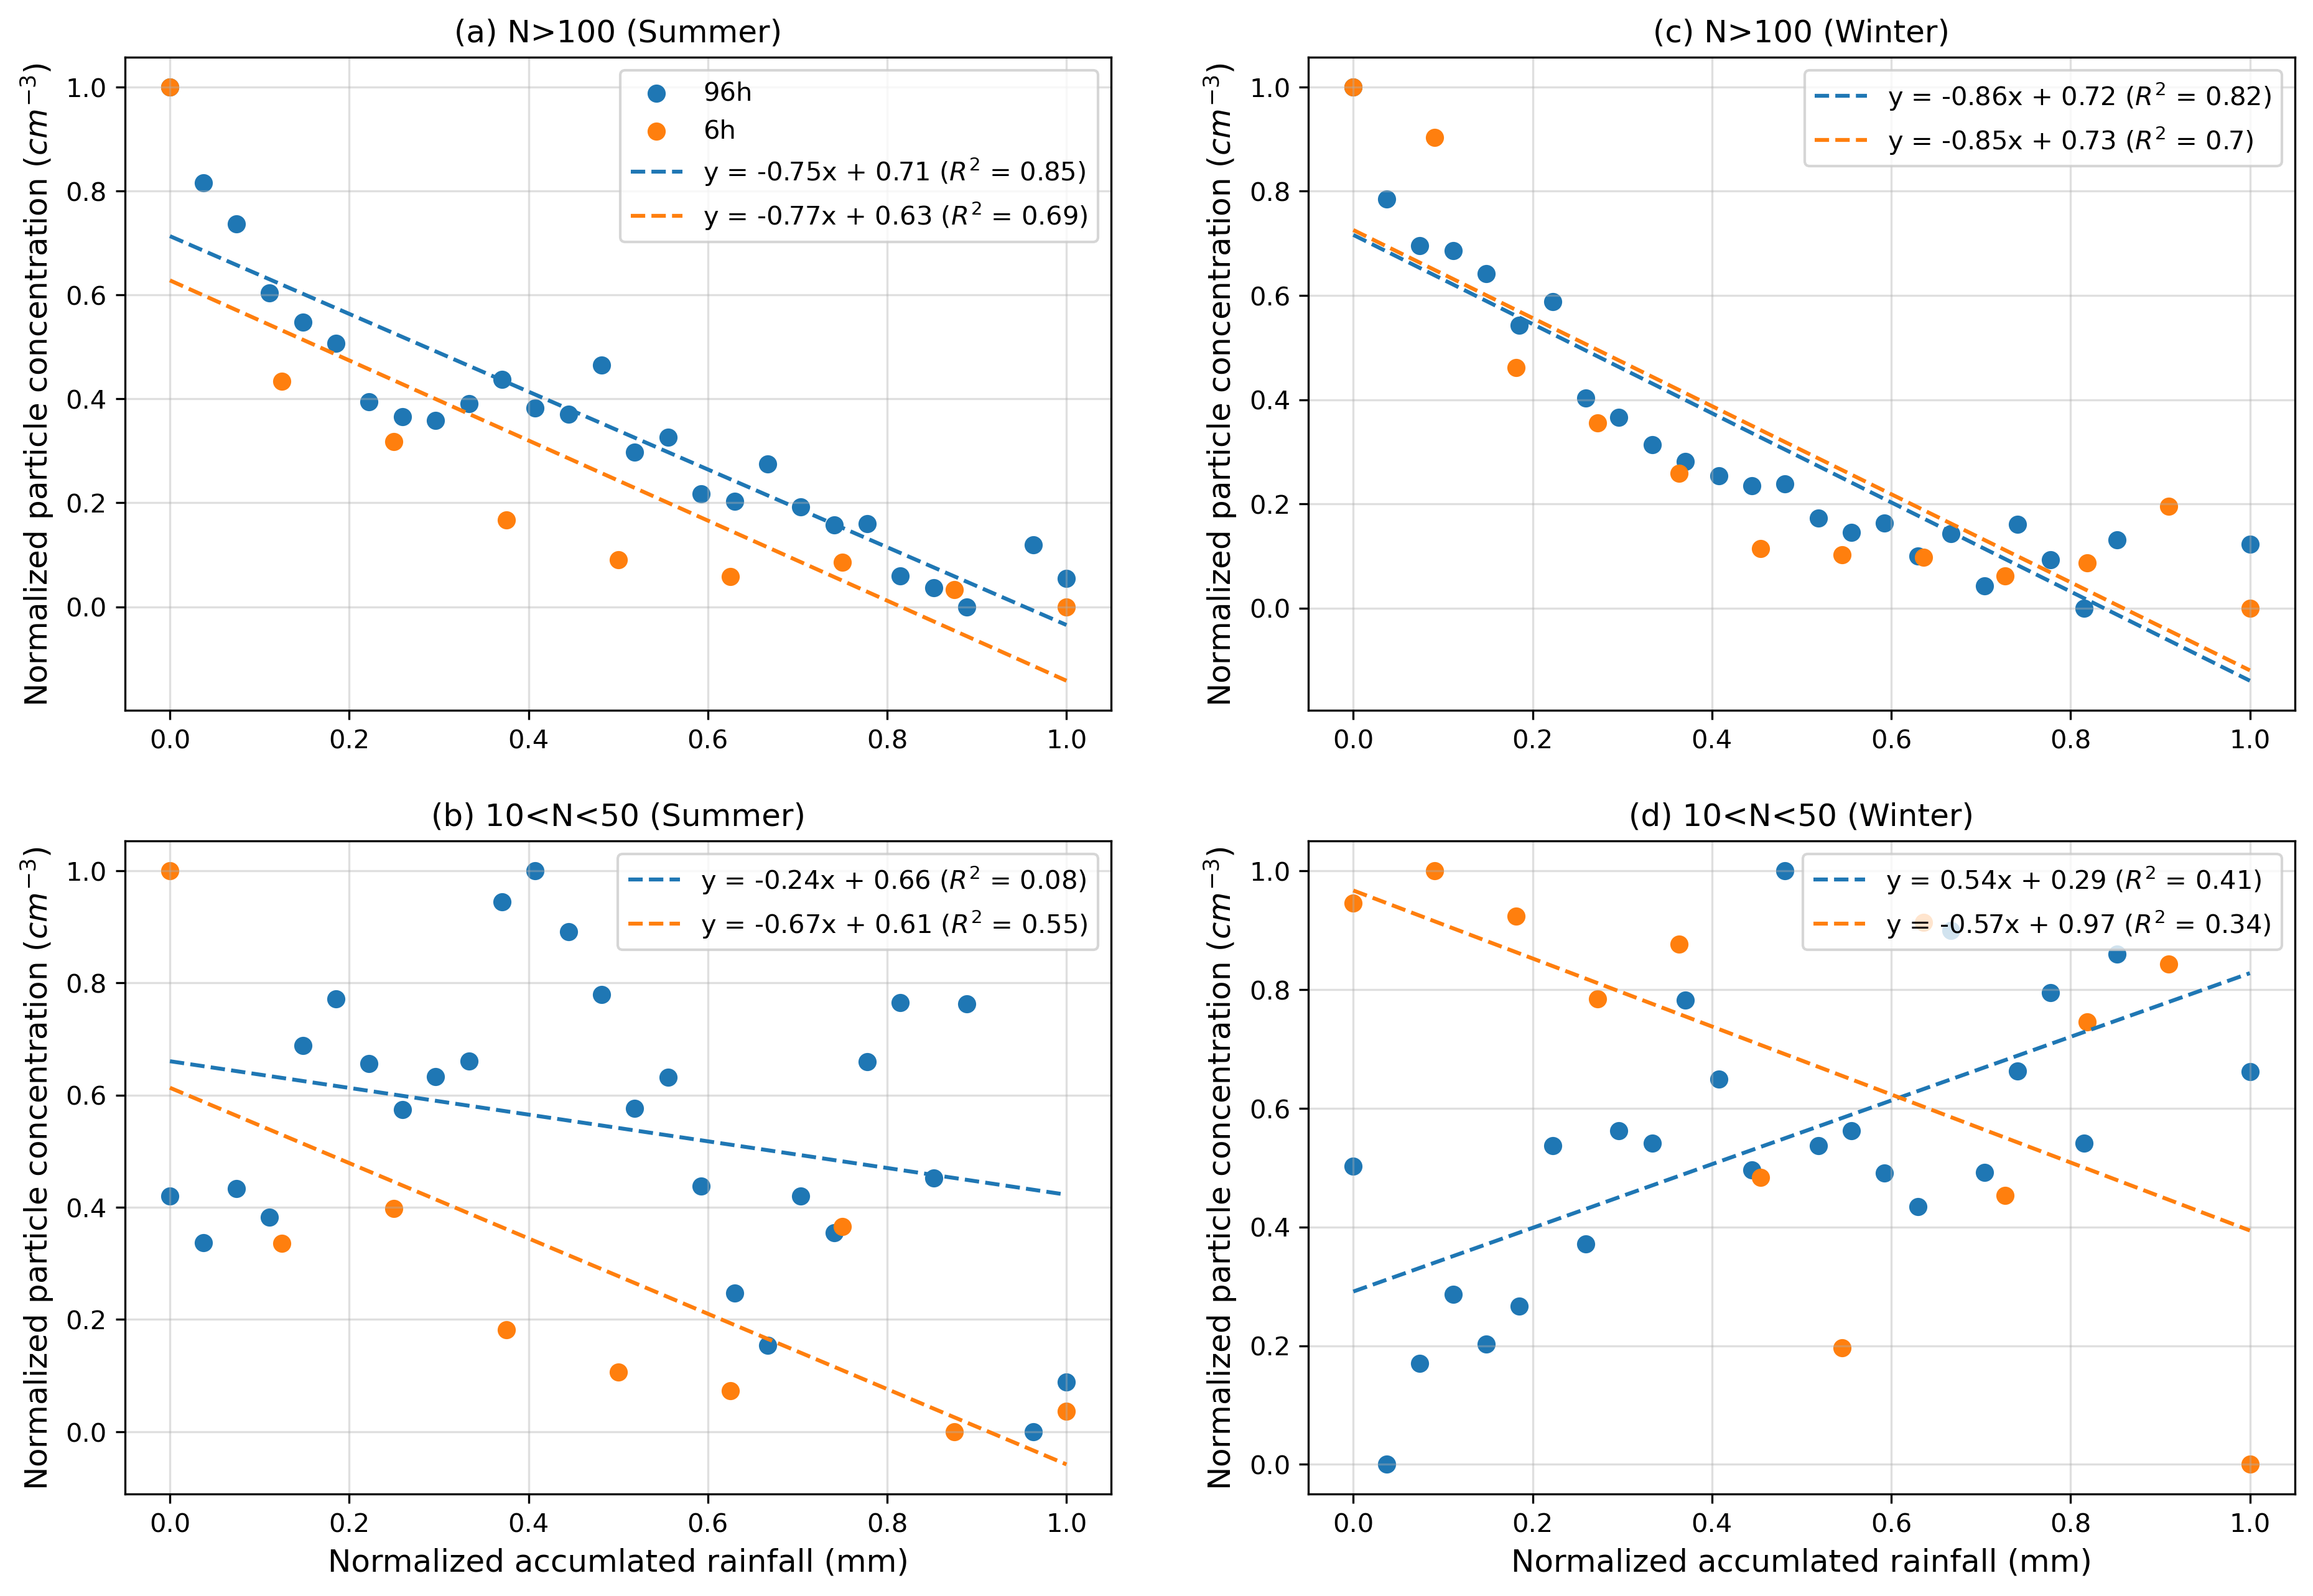

In [22]:
# Figure 3
fig = plt.figure(figsize=(15,10),dpi=300)

ax1 = plt.subplot(221)
ax1.scatter(nor_N100_96_warm.interval,nor_N100_96_warm.N100,label='96h')
ax1.scatter(nor_N100_6_warm.interval,nor_N100_6_warm.N100,label='6h')
plt.plot(nor_N100_96_warm.interval,pred_N100_96_warm, '--',label='y = ' + str(para_N100_96_warm[0][0].round(2)) + 'x + ' + str(para_N100_96_warm[1].round(2)) + ' ($R^{2}$ = '+ str(para_N100_96_warm[2].round(2)) + ')')
plt.plot(nor_N100_6_warm.interval,pred_N100_6_warm, '--',label='y = ' + str(para_N100_6_warm[0][0].round(2)) + 'x + ' + str(para_N100_6_warm[1].round(2)) + ' ($R^{2}$ = '+ str(para_N100_6_warm[2].round(2)) + ')')
plt.legend()
plt.title('(a) N>100 (Summer)')
plt.ylabel('Normalized particle concentration ($cm^{-3}$)',fontsize=12)
plt.grid(alpha=0.4)

ax2 = plt.subplot(223)
ax2.scatter(nor_N10_50_96_warm.interval,nor_N10_50_96_warm.N10_50)
ax2.scatter(nor_N10_50_6_warm.interval,nor_N10_50_6_warm.N10_50)
plt.plot(nor_N10_50_96_warm.interval,pred_N10_50_96_warm, '--',label='y = ' + str(para_N10_50_96_warm[0][0].round(2)) + 'x + ' + str(para_N10_50_96_warm[1].round(2)) + ' ($R^{2}$ = '+ str(para_N10_50_96_warm[2].round(2)) + ')')
plt.plot(nor_N10_50_6_warm.interval,pred_N10_50_6_warm, '--',label='y = ' + str(para_N10_50_6_warm[0][0].round(2)) + 'x + ' + str(para_N10_50_6_warm[1].round(2)) + ' ($R^{2}$ = '+ str(para_N10_50_6_warm[2].round(2)) + ')')
plt.legend()
plt.title('(b) 10<N<50 (Summer)')
plt.xlabel('Normalized accumlated rainfall (mm)',fontsize=12)
plt.ylabel('Normalized particle concentration ($cm^{-3}$)',fontsize=12)
plt.grid(alpha=0.4)

ax3 = plt.subplot(222)
ax3.scatter(nor_N100_96_cold.interval,nor_N100_96_cold.N100)
ax3.scatter(nor_N100_6_cold.interval,nor_N100_6_cold.N100)
plt.plot(nor_N100_96_cold.interval,pred_N100_96_cold, '--',label='y = ' + str(para_N100_96_cold[0][0].round(2)) + 'x + ' + str(para_N100_96_cold[1].round(2)) + ' ($R^{2}$ = '+ str(para_N100_96_cold[2].round(2)) + ')')
plt.plot(nor_N100_6_cold.interval,pred_N100_6_cold, '--',label='y = ' + str(para_N100_6_cold[0][0].round(2)) + 'x + ' + str(para_N100_6_cold[1].round(2)) + ' ($R^{2}$ = '+ str(para_N100_6_cold[2].round(2)) + ')')
plt.legend()
plt.title('(c) N>100 (Winter)')
plt.ylabel('Normalized particle concentration ($cm^{-3}$)',fontsize=12)
plt.grid(alpha=0.4)

ax4 = plt.subplot(224)
ax4.scatter(nor_N10_50_96_cold.interval,nor_N10_50_96_cold.N10_50)
ax4.scatter(nor_N10_50_6_cold.interval,nor_N10_50_6_cold.N10_50)
plt.plot(nor_N10_50_96_cold.interval,pred_N10_50_96_cold, '--',label='y = ' + str(para_N10_50_96_cold[0][0].round(2)) + 'x + ' + str(para_N10_50_96_cold[1].round(2)) + ' ($R^{2}$ = '+ str(para_N10_50_96_cold[2].round(2)) + ')')
plt.plot(nor_N10_50_6_cold.interval,pred_N10_50_6_cold, '--',label='y = ' + str(para_N10_50_6_cold[0][0].round(2)) + 'x + ' + str(para_N10_50_6_cold[1].round(2)) + ' ($R^{2}$ = '+ str(para_N10_50_6_cold[2].round(2)) + ')')
plt.legend(loc='upper right')
plt.title('(d) 10<N<50 (Winter)')
plt.xlabel('Normalized accumlated rainfall (mm)',fontsize=12)
plt.ylabel('Normalized particle concentration ($cm^{-3}$)',fontsize=12)
plt.grid(alpha=0.4)

Figure 3: Normalized accumulated concentrations for particles at Diameter > 100 nm (a,c) and 50 nm > Diameter > 10 nm (b,d) with normalized accumulated precipitation over 6 hours (orange) and 96 hours (blue), and their linear relationship in summer (a,b) and winter (c,d)

In Figure 3a, c, the negative influnece of rainfall is very significant for large particles in both seasons, with $R^{2}$ larger than 0.5. The influence of longer precipitation ($R^{2}$ = 0.85 for summer, $R^{2}$ = 0.82 for winter) is more pronounced than recent precipitation (($R^{2}$ = 0.69 for summer, $R^{2}$ = 0.70 for winter)).

While for small particles, the negative influnce of precipitation over 96h is not significant ($R^{2}$ = 0.08) (Figure 3b). But for more recent effect, particle concentration will be reduced by the precipitation ($R^{2}$ = 0.55) (Figure 4b). In the winter (Figure 4d), accumulated precipitation tend to increase small particle concentration in whole time trajectories but decrease it over last 6 hours, while with smaller $R^{2}$ value ($R^{2}$ = 0.41 for 96 hours, $R^{2}$ = 0.34 for 6 hours). Considering the precipitation accumulated over 6 hours, the negative effect on particle concentrations is more pronounced in summer than in winter (($R^{2}$ = 0.55 for summer, $R^{2}$ = 0.34 for winter)), which can support our hypothesis that more cloud fraction during precipitation inhibites solar radiation, thus inhibites the new particle formation.

Next we compare the simulated particle number size distribution and precipitation of NorESM2 model with the observations.

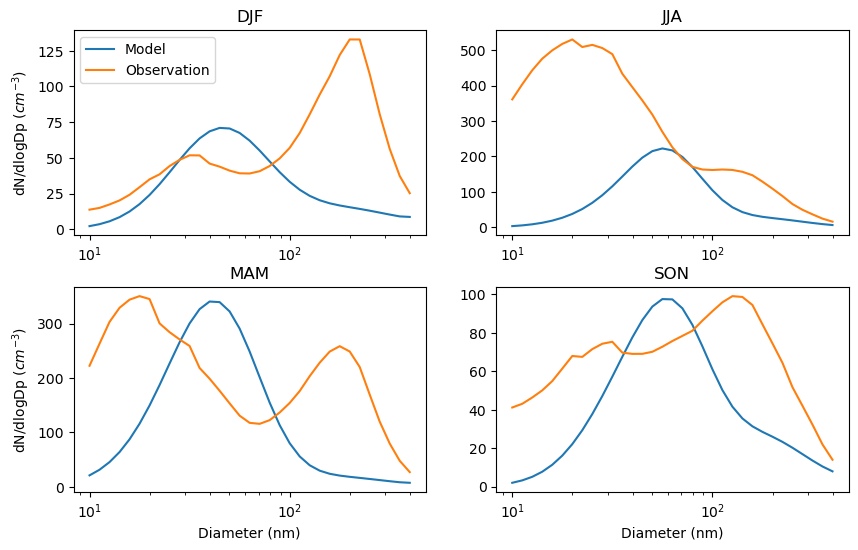

In [23]:
# Figure 4
data = data.sel(time=slice('2015-01-01','2017-12-31'))
model = model.sel(time=slice('2015-01-01','2017-12-31'))

season_pnsd_model = pd.DataFrame(model.pnsd.groupby('time.season').mean())
season_pnsd_model.index = np.array(['DJF','JJA','MAM','SON'])
season_pnsd_model.columns = model.D

season_pnsd_obs = pd.DataFrame(data.pnsd.groupby('time.season').mean())
season_pnsd_obs.index = np.array(['DJF','JJA','MAM','SON'])
season_pnsd_obs.columns = data.D

fig, axes = plt.subplots(figsize=(10, 6))
plt.subplots_adjust(hspace=0.25)
for i, season in enumerate(np.array(['DJF','JJA','MAM','SON'])):
    ax = plt.subplot(2,2,i+1)
    season_pnsd_model.iloc[i,:].plot(label='Model')
    season_pnsd_obs.iloc[i,:].plot(label='Observation')
    plt.title('{}'.format(season))
    ax.set_xscale('log')
    if i > 1:
        plt.xlabel('Diameter (nm)')
    if i == 0 or i == 2:
        plt.ylabel('dN/dlogDp ($cm^{-3}$)')
    if i == 0:
        plt.legend()

Figure 4: Seasonal comparison between observational (orange) and modelled (blue) particle number size distribution.

Figure 4 shows the observational and modelled particle number size distribution (from 10 to 400 nm) in different seasons. In general, NorESM2 can't simulate the particle number size distribution very well, both for aitken mode and accumulation mode. Aitken mode particle concentrations are underestimated in each season, with the difference reaching the largest in summer, when the aitken mode particles are most abundant. NorESM2 also underestimates the accumulation mode particle concentrations, with winter seeing the largest underestimation, when the accumulation mode particles are relatively dominant.

In Figure 5 we can see the monthly comparison between observation and model. It can be observed that in month 11, 12, 1, 2, 3 the accumulation mode particle concentrations are obviously underestimated, and in month 5, 6, 7, 8 the aitken mode particle concentrations are largely underestimated.

Informed by Sara Blichner, who runs the NorESM2 model, the nucleation mode was not included in the aerosol scheme, explaining the large deficit of aitken mode particle concentrations in the model. While we still find the underestimation of large accumulation mode particles in the NorESM2 model.

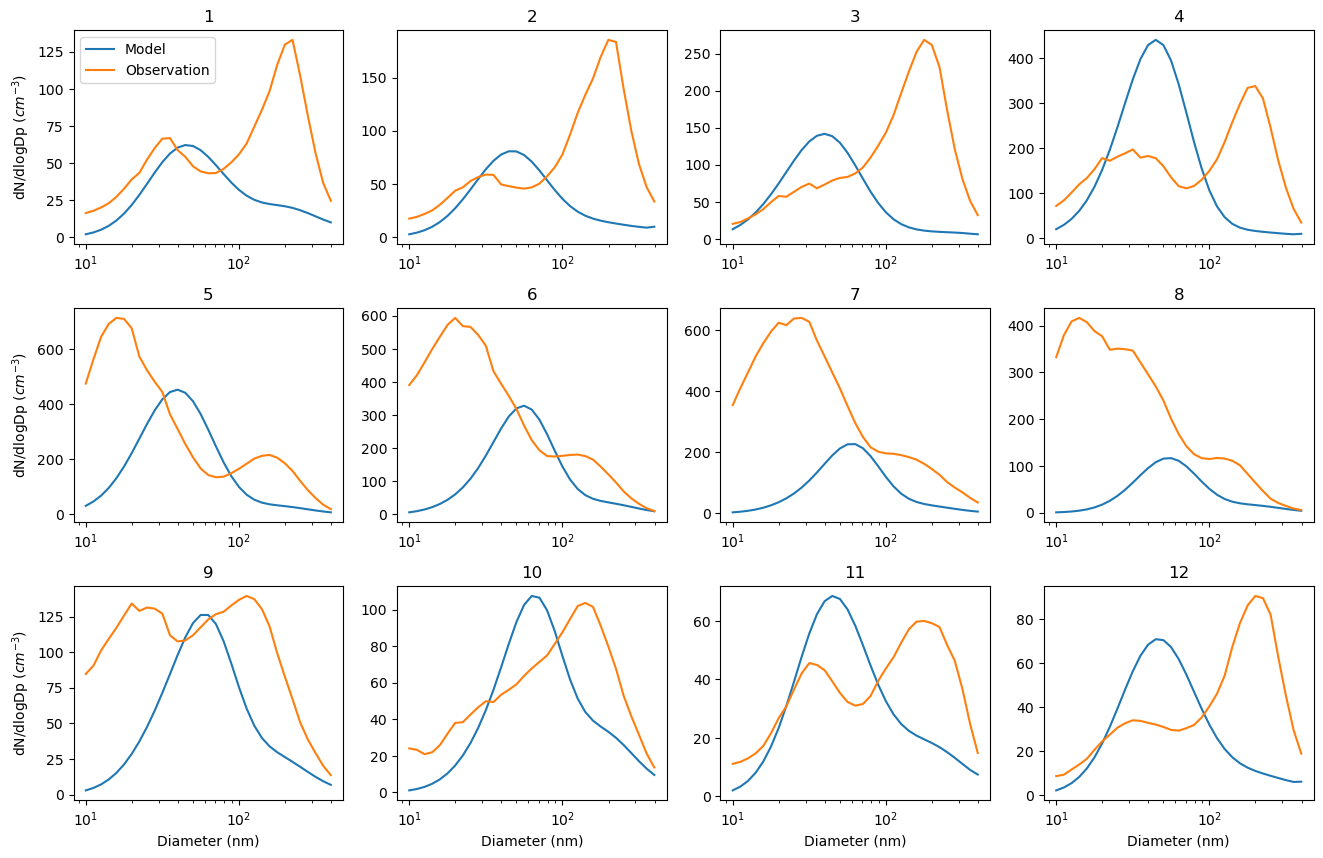

In [24]:
# Figure 5
monthly_pnsd_model = pd.DataFrame(model.pnsd.groupby('time.month').mean())
monthly_pnsd_model.index = np.arange(1,13)
monthly_pnsd_model.columns = model.D

monthly_pnsd_obs = pd.DataFrame(data.pnsd.groupby('time.month').mean())
monthly_pnsd_obs.index = np.arange(1,13)
monthly_pnsd_obs.columns = data.D

fig, axes = plt.subplots(figsize=(16, 10))
plt.subplots_adjust(hspace=0.3)
for i in np.arange(12):
    ax = plt.subplot(3,4,i+1)
    monthly_pnsd_model.iloc[i,:].plot(label='Model')
    monthly_pnsd_obs.iloc[i,:].plot(label='Observation')
    plt.title('{}'.format(i+1))
    ax.set_xscale('log')
    if i > 7:
        plt.xlabel('Diameter (nm)')
    if i == 0 or i == 4 or i == 8:
        plt.ylabel('dN/dlogDp ($cm^{-3}$)')
    if i == 0:
        plt.legend()

Figure 5: Monthly comparison between observational (orange) and modelled (blue) particle number size distribution.



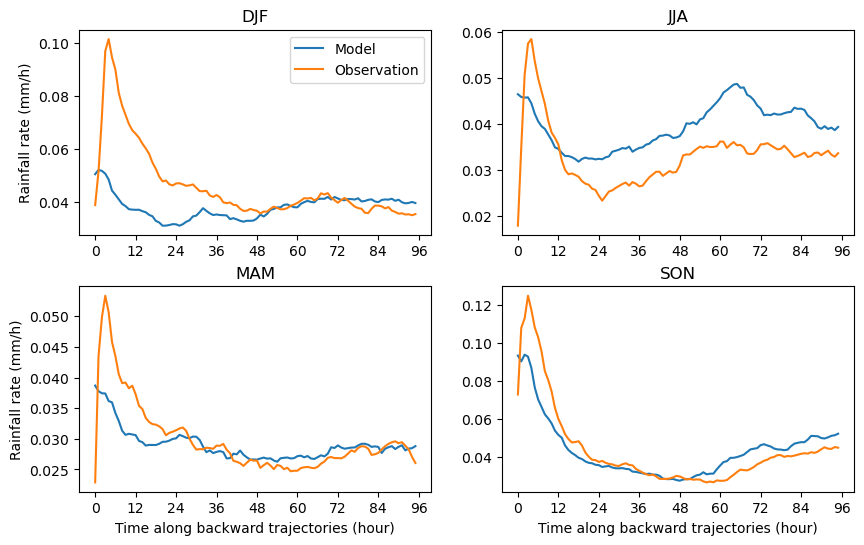

In [25]:
# Figure 6
model['Rainfall'] = (model.Convective_precip + model.Large_precip)*3600*1000

season_rain_model = pd.DataFrame(model.Rainfall.groupby('time.season').mean())
season_rain_model.index = np.array(['DJF','JJA','MAM','SON'])
season_rain_model.columns = model.time_traj

season_rain_obs = pd.DataFrame(data.Rainfall.groupby('time.season').mean())
season_rain_obs.index = np.array(['DJF','JJA','MAM','SON'])
season_rain_obs.columns = data.time_traj

fig, axes = plt.subplots(figsize=(10, 6))
plt.subplots_adjust(hspace=0.25)
for i, season in enumerate(np.array(['DJF','JJA','MAM','SON'])):
    ax = plt.subplot(2,2,i+1)
    season_rain_model.iloc[i,:].plot(label='Model', xticks=np.linspace(0,96,9))
    season_rain_obs.iloc[i,:].plot(label='Observation')
    plt.title('{}'.format(season))
    if i > 1:
        plt.xlabel('Time along backward trajectories (hour)')
    if i == 0 or i == 2:
        plt.ylabel('Rainfall rate (mm/h)')
    if i == 0:
        plt.legend()

Figure 6: Seasonal comparison between observational (orange) and modelled (blue) rainfall rate.

Looking at the precipitation, NorESM2 can catch the magnitude and trend of precipitation in each season (Figure 6). Nevertheless, in summer, there is an overestimation of about 0.01 mm/h before 12 hours. Additionally, there is an underestimation of precipitation in 48 hours in winter. 

Figure 7 shows the monthly comparison of precipitation between observation and model. From it we can see that NorSEM2 catch the characteristics of precipitation very well, especially in month 3, 4, 9, 10, 11. The overestimation of precipitation can be observed in month 6, 7, 8 and underestimation can be found in month 1, 11, 12.

One notable point for observation is that there is a jump of precipitation at around 3 hours in each season and each month. There is a location that has a lot of precipitation around three hours from the Zeppelin station, which has to be investigated in detail in the future.

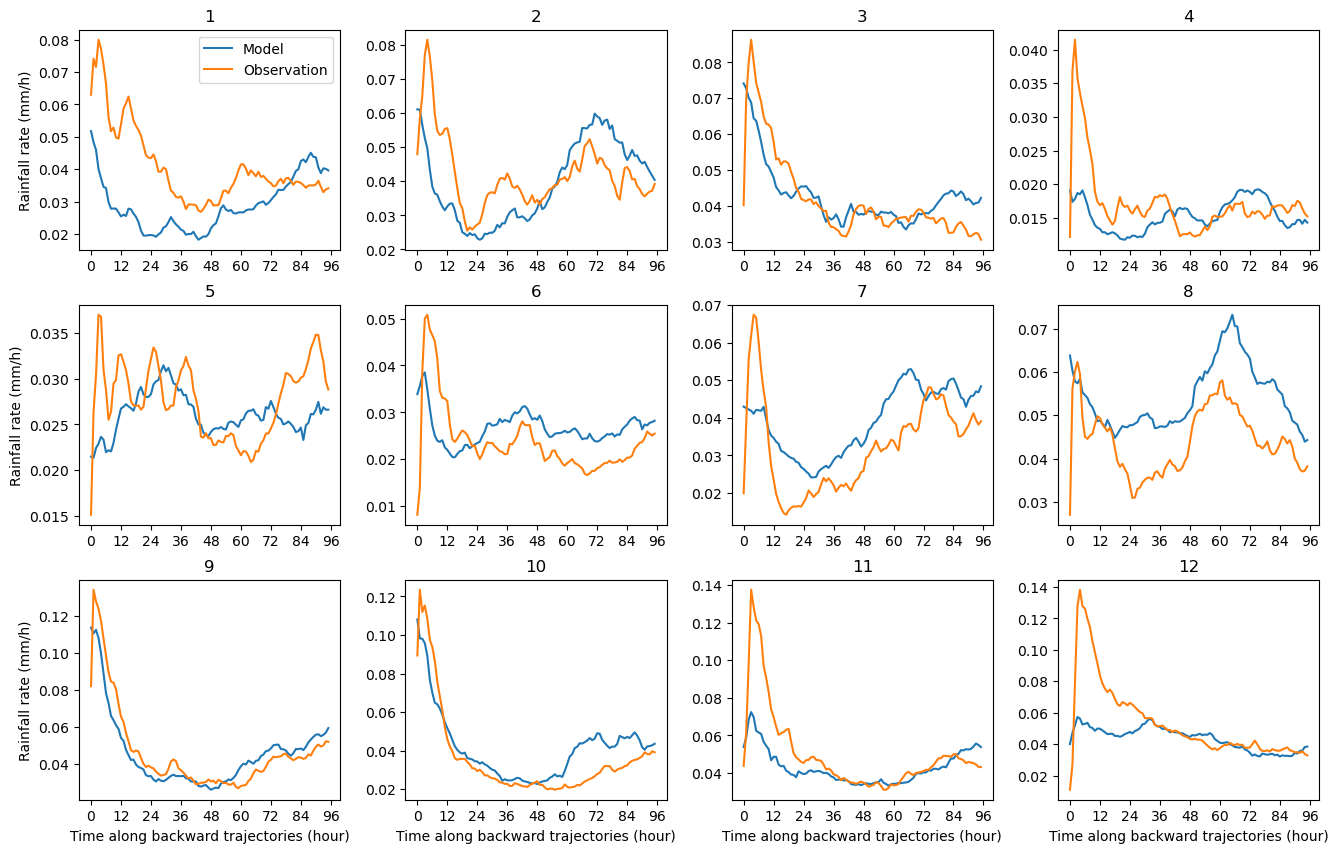

In [27]:
# Figure 7
monthly_rain_model = pd.DataFrame(model.Rainfall.groupby('time.month').mean())
monthly_rain_model.index = np.arange(1,13)
monthly_rain_model.columns = model.time_traj

monthly_rain_obs = pd.DataFrame(data.Rainfall.groupby('time.month').mean())
monthly_rain_obs.index = np.arange(1,13)
monthly_rain_obs.columns = data.time_traj

fig, axes = plt.subplots(figsize=(16, 10))
plt.subplots_adjust(hspace=0.25)
plt.subplots_adjust(wspace=0.25)
for i in np.arange(12):
    ax = plt.subplot(3,4,i+1)
    monthly_rain_model.iloc[i,:].plot(label='Model', xticks=np.linspace(0,96,9))
    monthly_rain_obs.iloc[i,:].plot(label='Observation')
    plt.title('{}'.format(i+1))
    if i > 7:
        plt.xlabel('Time along backward trajectories (hour)',fontsize=10)
    if i == 0 or i == 4 or i == 8:
        plt.ylabel('Rainfall rate (mm/h)',fontsize=10)
    if i == 0:
        plt.legend()

Figure 7: Monthly comparison between observational (orange) and modelled (blue) rainfall rate.

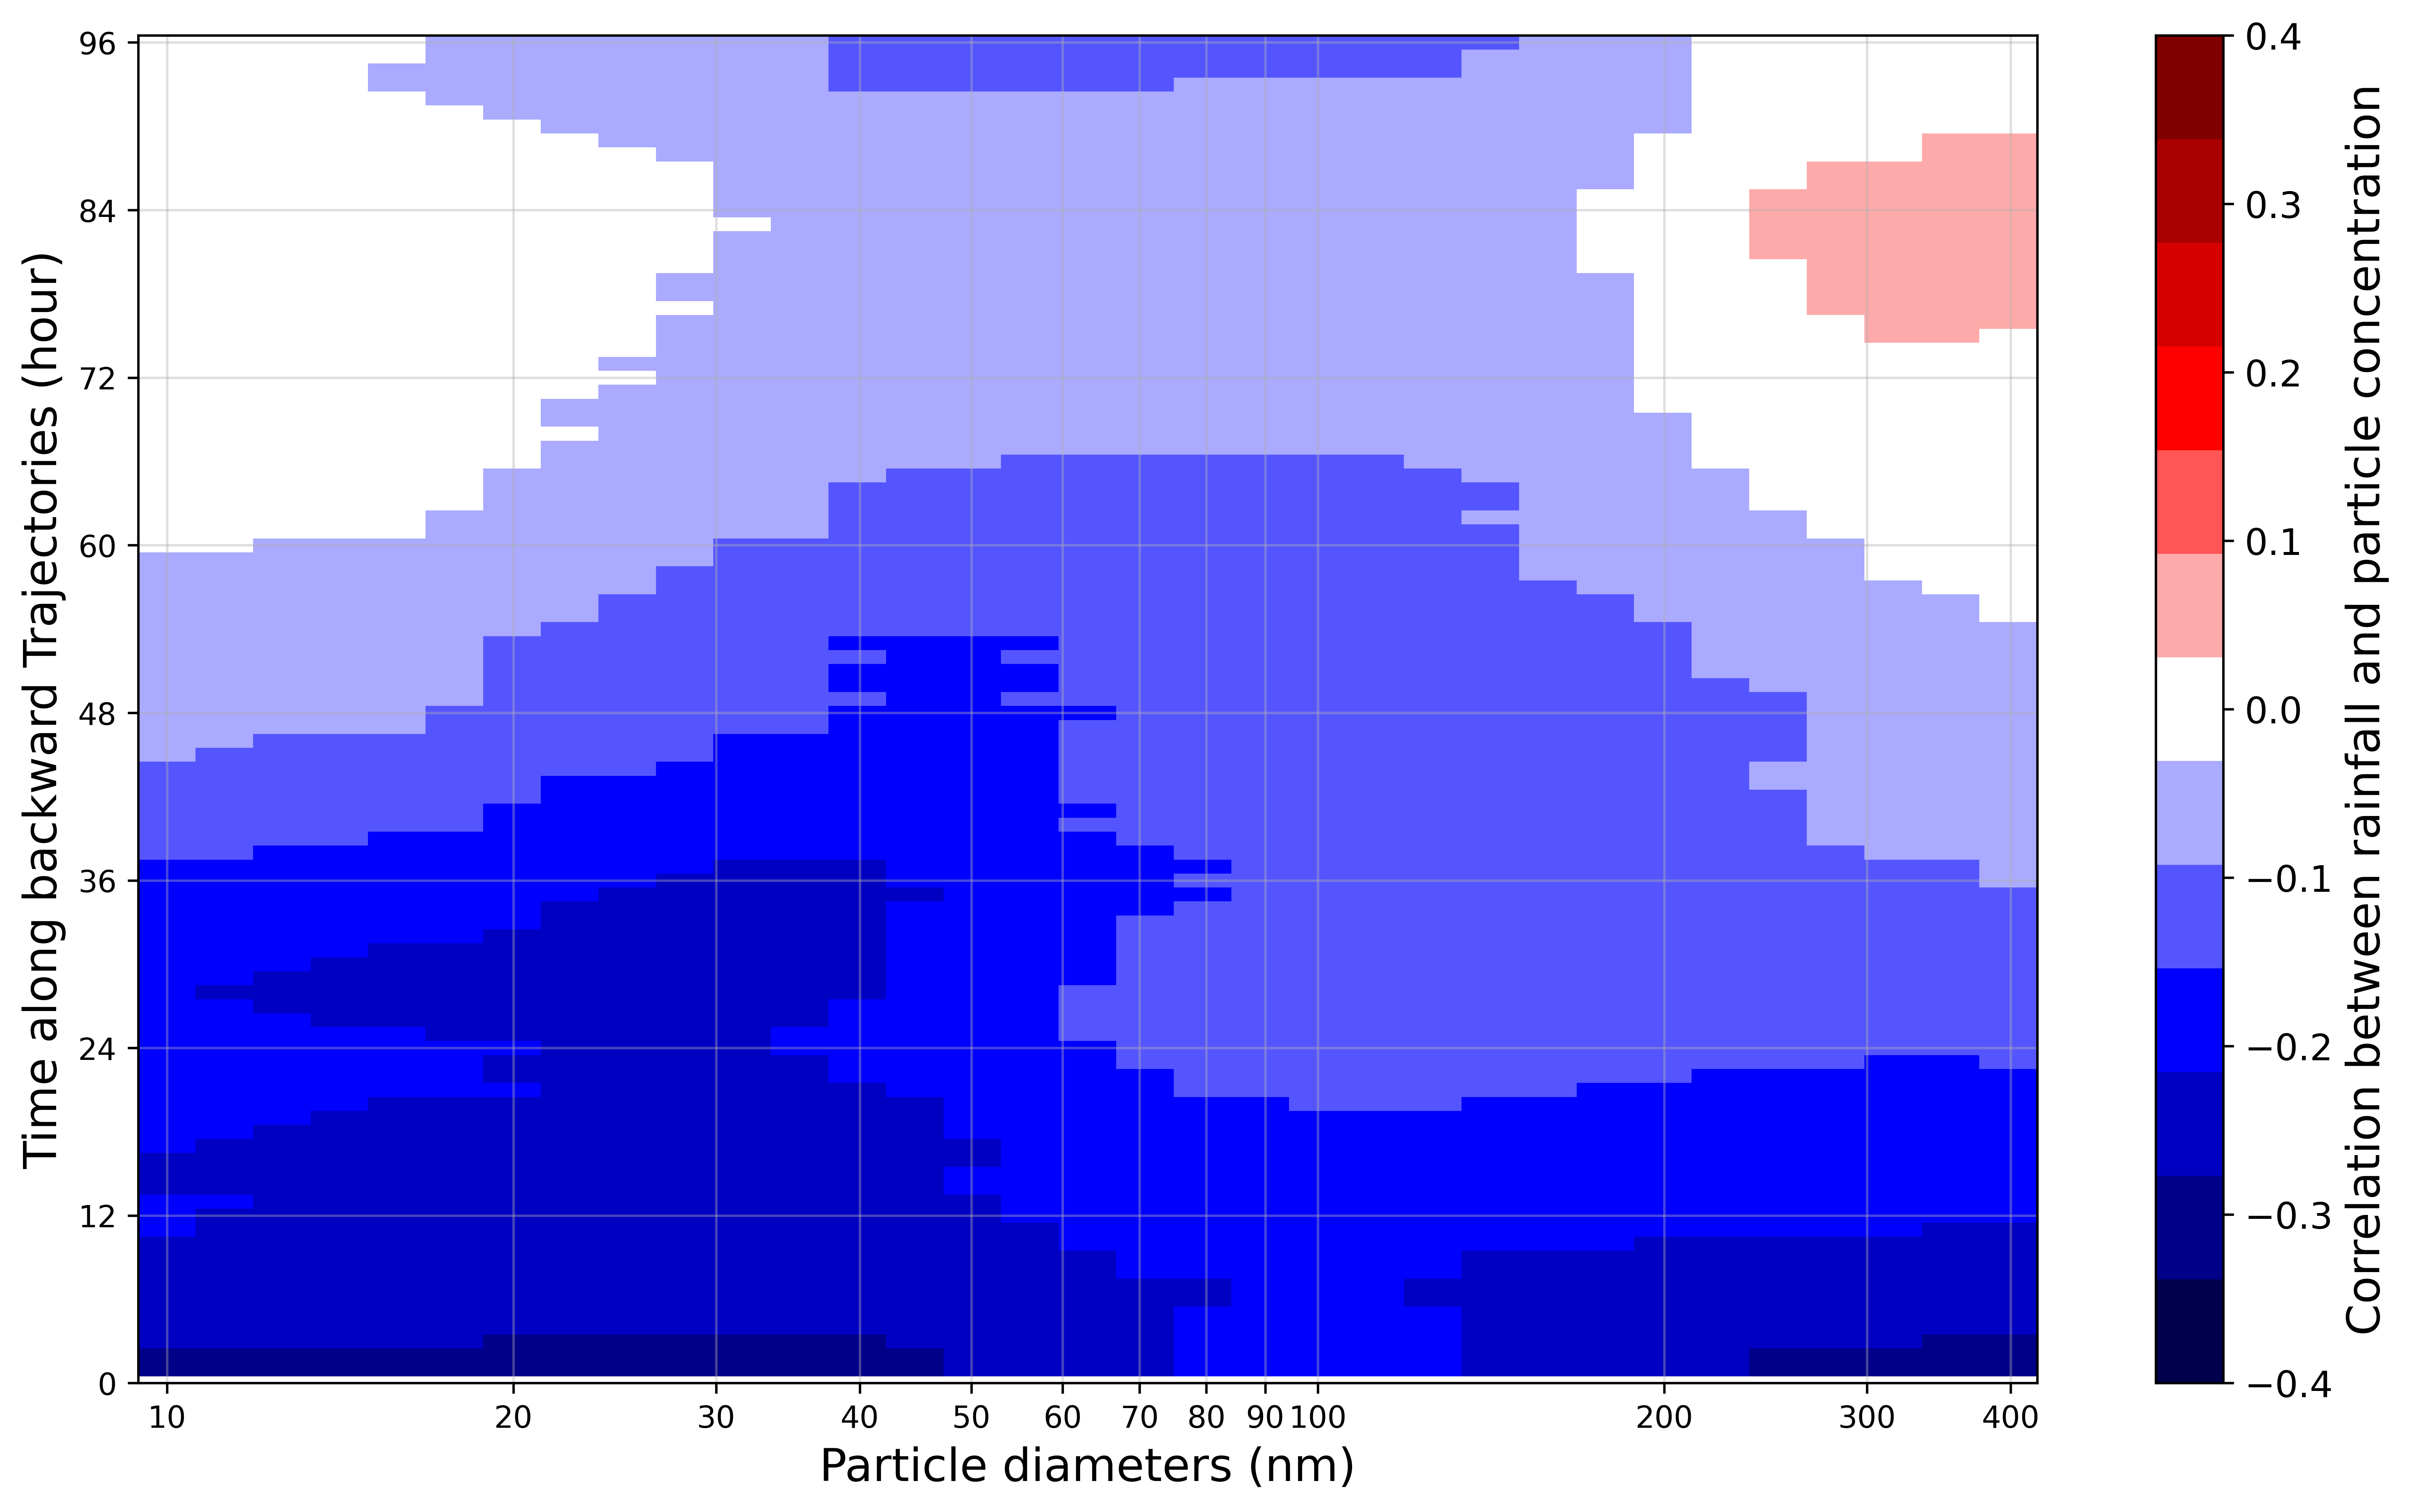

In [28]:
# Figure 8
fig = plt.figure(figsize=(14,8), dpi=600)
ax = plt.subplot()

X, Y = np.meshgrid(centers,bound_bins)
cmap = plt.get_cmap('seismic',lut=13)
mappable = ax.pcolor(Y, X, model_cor_pre, cmap=cmap, vmax=0.4, vmin=-0.4)

ax.set_xscale('log')
ax.set_xticks([10,20,30,40,50,60,70,80,90,100,200,300,400])
ax.set_yticks(np.arange(0,97,12))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

cbar = plt.colorbar(mappable)
plt.xlabel('Particle diameters (nm)',fontsize=15)
plt.ylabel('Time along backward Trajectories (hour)',fontsize=15)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='Correlation between rainfall and particle concentration',size=15)
plt.grid(alpha=0.4)

Figure 8: Correlation between simulated precipitation rate and particle number size distribution by NorESM2 at given time steps of the 96h backward airmass trajectories.

After evaluating the particle number size distribution and precipitation simulated by NorESM2 model, we can investigate the relationship between rainfall rate and particle concentration (Figure 8). The negative effect of precipitation on particle concentrations can be observed for both large and small particles. At the very first time steps, the negative influence is the strongest, and then weakens along the backward time trajectories. Compared to the observations, the negative influence on particles whose diameter are larger than 100 nm weakens faster in the model, but the influence on particles smaller than 50 nm lasts longer. While the wet scavenging is well represented, the effect of condensation sink which let small aerosols have longer life time is hardly seen in the model.

## 5. Conclusion

In this report, we use 10-year observations of particle number size distribution at Zeppelin Station and collocated backward trajectory precipitation to explore the influence of recent and old precipitation on concentrations of particles of different sizes. Moreover, the ability of NorESM model to simulate the aerosol concentrations, precipitation and their relationships is evaluated. Below are our conclusions:

1. Precipitation can act as both a sink (wet scavenging, inhibited NPF) and a source (lowered condensation sink) for aerosols of different sizes.
2. NorESM2 simulates the precipitation well but needs to improve the aerosol simulation, especially for accumulation mode.
3. NorESM2 can catch the characteristics of wet scavenging but needs to include the condensation sink into the model.

For future work, the NorESM2 model should be evaluated at different locations such as tropic and Antarctica to further confirm the relationship between precipitation and aerosol concentrations in the model. The results of evaluation should be used to inform the model development.

## 6. Acknowledgement

I would like to thank our group assistant, Theodore, for his guidance on this project and generous answering for my questions. I would like to thank Sara for providing the NorESM2 model data. I would like to thank our group members Arttu and Ingrid for their supports and interesting conversations. I would also like to thank Paul and Micheal for organizing this meaningful course. Lastly I would like to thank my institution Australian Antarctic Program Partnership for funding this travel.

## 7. Reference

Riipinen, I., Pierce, J. R., Yli-Juuti, T., Nieminen, T., Häkkinen, S., Ehn, M., Junninen, H., Lehtipalo, K., Petäjä, T., Slowik, J., Chang, R., Shantz, N. C., Abbatt, J., Leaitch, W. R., Kerminen, V.-M., Worsnop, D. R., Pandis, S. N., Donahue, N. M., and Kulmala, M.: Organic condensation: a vital link connecting aerosol formation to cloud condensation nuclei (CCN) concentrations, Atmos. Chem. Phys., 11, 3865–3878, https://doi.org/10.5194/acp-11-3865-2011, 2011.

Seinfeld, John H., and Spyros N. Pandis. "From air pollution to climate change." Atmospheric chemistry and physics 1326 (1998).

Tunved, P., Ström, J., and Krejci, R.: Arctic aerosol life cycle: linking aerosol size distributions observed between 2000 and 2010 with air mass transport and precipitation at Zeppelin station, Ny-Ålesund, Svalbard, Atmos. Chem. Phys., 13, 3643–3660, https://doi.org/10.5194/acp-13-3643-2013, 2013.

Westervelt, D. M., Pierce, J. R., Riipinen, I., Trivitayanurak, W., Hamed, A., Kulmala, M., Laaksonen, A., Decesari, S., and Adams, P. J.: Formation and growth of nucleated particles into cloud condensation nuclei: model–measurement comparison, Atmos. Chem. Phys., 13, 7645–7663, https://doi.org/10.5194/acp-13-7645-2013, 2013.